### Assigment 4

**Submission deadlines**:

* get at least 4 points by 17.05.2023
* remaining points: last lab session before or on 26.05.2023

**Points:** Aim to get 12 out of 15+ possible points

All needed data files should be on Drive: <https://drive.google.com/drive/folders/1HaMbhzaBxxNa_z_QJXSDCbv5VddmhVVZ?usp=sharing> 

## Task 1 (5 points)

Implement simplified word2vec with negative sampling from scratch (using pure numpy). Assume that in the training data objects and contexts are given explicitly, one pair per line, and objects are on the left. The result of the training should be object vectors. Please, write them to a file using *natural* text format, ie

<pre>
word1 x1_1 x1_2 ... x1_N 
word2 x2_1 x2_2 ... x2_N
...
wordK xK_1 xK_2 ... xk_N
</pre>

Use the loss from Slide 25 in Lecture NLP.01, compute the gradient manually. You can use some gradient clipping, or regularisation. 

**Remark**: the data is specially prepared to make the learning process easier. 
Present vectors using the code below. In this task we define success as 'obtaining a result which looks definitely not random'


In [ ]:
import numpy as np
import random
from collections import Counter
from collections import defaultdict
from gensim.test.utils import common_texts
from gensim.models import Word2Vec


In [ ]:
! gdown 'https://drive.google.com/uc?id=1a6Rki9MJwxq8m6HdqgMoS_iSLIGXIlia'
! ls

Downloading...
From: https://drive.google.com/uc?id=1a6Rki9MJwxq8m6HdqgMoS_iSLIGXIlia
To: /content/task1_objects_contexts_polish.txt.gz
100% 47.0M/47.0M [00:01<00:00, 33.8MB/s]
sample_data  task1_objects_contexts_polish.txt.gz


In [ ]:
! gzip -d task1_objects_contexts_polish.txt.gz

In [ ]:
with open('task1_objects_contexts_polish.txt', 'r') as file:
    content = file.read()
lines = content.split('\n')
processed_lines = []
for line in lines:
    parts = line.split(' ')
    if len(parts) == 2:
        second_string = parts[1].split('_')[-1]
        processed_line = parts[0] + ' ' + second_string
        processed_lines.append(processed_line)
with open('./task1_polish.txt', 'w') as file:
    file.write('\n'.join(processed_lines))


In [ ]:
data = []
with open('task1_polish.txt','r') as f:
    for line in f.readlines():
        data.append(line.strip())

In [ ]:
class W2V_model:
    def __init__(self, embedding_size=50, learning_rate=0.01, num_negative_samples=5):
        self.embedding_size = embedding_size
        self.learning_rate = learning_rate
        self.num_negative_samples = num_negative_samples
        self.vocab_size = None
        self.word2id = None
        self.id2word = None
        self.W1 = None
        self.W2 = None

    def preprocess_data(self, data):
        word_counts = Counter()
        for line in data:
            obj, context = line.strip().split()
            word_counts.update([obj, context])

        self.word2id = {w: i for i, (w, _) in enumerate(word_counts.most_common())}
        self.id2word = {i: w for w, i in self.word2id.items()}
        self.vocab_size = len(self.word2id)

    def initialize_weights(self):
        self.W1 = np.random.uniform(-0.8, 0.8, (self.vocab_size, self.embedding_size))
        self.W2 = np.random.uniform(-0.8, 0.8, (self.vocab_size, self.embedding_size))

    def train(self, data, num_epochs=5):
        self.preprocess_data(data)
        self.initialize_weights()

        for epoch in range(num_epochs):
            loss = 0
            for line in data:
                obj, context = line.strip().split()
                obj_id = self.word2id[obj]
                context_id = self.word2id[context]
                negative_samples = self.get_negative_samples([obj_id, context_id])

                loss += self.train_step(obj_id, context_id, negative_samples)

            print(f"Epoch: {epoch+1}/{num_epochs}, Loss: {loss}")

    def get_negative_samples(self, target_context_ids):
        negative_samples = []
        while len(negative_samples) < self.num_negative_samples:
            sample = np.random.randint(0, self.vocab_size)
            if sample not in target_context_ids:
                negative_samples.append(sample)
        return negative_samples

    def train_step(self, target_word_id, context_word_id, negative_samples):
        target_embedding = self.W1[target_word_id]
        context_embedding = self.W2[context_word_id]

        negative_embeddings = self.W2[negative_samples]

        positive_score = np.dot(target_embedding, context_embedding)
        negative_scores = np.dot(negative_embeddings, target_embedding)

        positive_activation = 1 / (1 + np.exp(-positive_score))
        negative_activations = 1 / (1 + np.exp(negative_scores))

        grad_pos = positive_activation - 1
        grad_neg = negative_activations

        self.W1[target_word_id] -= self.learning_rate * np.dot(grad_pos, context_embedding)
        self.W2[context_word_id] -= self.learning_rate * grad_pos * target_embedding
        self.W2[negative_samples] -= self.learning_rate * np.outer(grad_neg, target_embedding)

        loss = -np.log(positive_activation) - np.sum(np.log(1 - negative_activations))
        return loss

    def get_object_vectors(self):
        return self.W1


In [ ]:
W2V_model = W2V_model(embedding_size=50, learning_rate=0.01, num_negative_samples=5)

W2V_model.train(data, num_epochs=10)
object_vectors = W2V_model.get_object_vectors()

with open("word_vectors.txt", "w") as file:
  for i, vector in enumerate(object_vectors):
      word = W2V_model.id2word[i]
      file.write(f"{word} {' '.join(str(v) for v in vector)}\n")


Epoch: 1/10, Loss: 29485992.844938524
Epoch: 2/10, Loss: 28706921.57979213
Epoch: 3/10, Loss: 31123344.021877687
Epoch: 4/10, Loss: 33282088.906548247
Epoch: 5/10, Loss: 33746219.28854966
Epoch: 6/10, Loss: 34284427.89153955
Epoch: 7/10, Loss: 35210584.45574225
Epoch: 8/10, Loss: 36352708.9695066
Epoch: 9/10, Loss: 37610529.56356697
Epoch: 10/10, Loss: 38899362.14602157


In [ ]:
# data preparation 

# w2v_path = './word_vectors.txt'
# num_lines = sum(1 for _ in open(w2v_path))

# line_to_insert = str(num_lines)+' '+'50'

# with open(w2v_path, 'r+') as file:
#     content = file.read()
#     file.seek(0, 0)
#     file.write(line_to_insert.rstrip('\r\n') + '\n' + content)


In [ ]:
from gensim.models import KeyedVectors
task1_wv = KeyedVectors.load_word2vec_format('./word_vectors.txt', binary=False, encoding="utf-8")

# example_english_words = ['dog', 'dragon', 'love', 'bicycle', 'marathon', 'logic', 'butterfly']  # replace, or add your own examples
example_polish_words = ['rowerzysta', 'albania', 'zaciekłość', 'korzystanie', 'zaniżanie', 'dwójka', 'pokazanie']

example_words = example_polish_words

for w0 in example_words:
    print ('WORD:', w0)
    for w, v in task1_wv.most_similar(w0):
        print ('   ', w, v)
    print ()

WORD: rowerzysta
    łokaś 0.558108389377594
    pozasłaniać 0.5259906649589539
    treblinka 0.5243805646896362
    bujniejszy 0.5133177638053894
    ostrzyc 0.5076439380645752
    mężnienie 0.5074706673622131
    preromantyk 0.4996197819709778
    parasolowy 0.4955679178237915
    koryznówka 0.49486497044563293
    geometryzacja 0.49159136414527893

WORD: albania
    krótszy 0.6149526834487915
    nadleśniczy 0.5764672160148621
    tajlandia 0.573524534702301
    francja 0.5595162510871887
    dokopywanie 0.5478132963180542
    ameryka 0.5465968251228333
    podwiezienie 0.5462141036987305
    łobodziński 0.5405531525611877
    bułgaria 0.5301722884178162
    nadpłacany 0.5245251059532166

WORD: zaciekłość
    kląskanie 0.5575346946716309
    uwiarygodnić 0.5463721752166748
    przesmażony 0.523444652557373
    usiłowany 0.5182299017906189
    nieszczęście 0.516676127910614
    lipczak 0.508350670337677
    dolegliwość 0.5082070827484131
    osamotnienie 0.5041132569313049
    brutal

## Task 2 (4 points)

Your task is to train the embeddings for Simple Wikipedia titles, using gensim library. As the example below shows, training is really simple:

```python
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
model = Word2Vec(sentences=common_texts, vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")
```
*sentences* can be a list of list of tokens, you can also use *gensim.models.word2vec.LineSentence(source)* to create restartable iterator from file. At first, use [this file] containing such pairs of titles, that one article links to another.

We say that two titles are *related* if they both contain a word (or a word bigram) which is not very popular (it occurs only in several titles). Make this definition more precise, and create the corpora which contains pairs of related titles. Make a mixture of the original corpora, and the new one, then train title vectors again.

Compare these two approaches using similar code to the code from Task 1.

In [ ]:
from gensim.models import Word2Vec, fasttext
from gensim.models.word2vec import LineSentence
from gensim.models.word2vec import Word2Vec,LineSentence
import multiprocessing

In [ ]:
# download data
! gdown 'https://drive.google.com/uc?id=1gEJq8jT-7pmda6t_aoT4iQHRU9HmQUh0'

Downloading...
From: https://drive.google.com/uc?id=1gEJq8jT-7pmda6t_aoT4iQHRU9HmQUh0
To: /content/task2_simple.wiki.links.txt.gz
100% 124M/124M [00:00<00:00, 158MB/s]


In [ ]:
! gzip -d task2_simple.wiki.links.txt.gz
! ls

sample_data			   task1_polish.txt
task1_objects_contexts_polish.txt  task2_simple.wiki.links.txt


In [ ]:
# train & save model
model = Word2Vec(LineSentence('task2_simple.wiki.links.txt'),workers=multiprocessing.cpu_count())
model.init_sims(replace=True)
model.save('wiki.model')


<ipython-input-44-e29b674292f2>:2: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model.init_sims(replace=True)


In [ ]:
model =  Word2Vec.load('wiki.model')
# test
print(model.wv.most_similar("november_1"))
print(model.wv.most_similar("poland"))
print(model.wv.most_similar("iron_poisoning"))

[('november_25', 0.9922276139259338), ('november_15', 0.9915652275085449), ('october_12', 0.9914483428001404), ('december_12', 0.9913377165794373), ('december_16', 0.9912872314453125), ('august_22', 0.9907470941543579), ('march_29', 0.9907252788543701), ('september_5', 0.990696132183075), ('january_25', 0.9904808402061462), ('march_11', 0.9903876781463623)]
[('hungary', 0.9476350545883179), ('norway', 0.9428160786628723), ('denmark', 0.9419586062431335), ('finland', 0.9359192848205566), ('czech_republic', 0.930668830871582), ('netherlands', 0.9299182295799255), ('russia', 0.9296722412109375), ('greece', 0.9207050204277039), ('ukraine', 0.908385157585144), ('belgium', 0.9073256254196167)]
[('template:tumours', 0.9805005788803101), ('khairpur,_pakistan', 0.9803885221481323), ('fruits', 0.9802930355072021), ('reassortment', 0.9799234867095947), ('quantum_theory', 0.9799146056175232), ('abrahamic_religions', 0.9797009229660034), ('aseptic_meningitis', 0.979562520980835), ('template:mp_smal

In [ ]:
# example
example_wikis = ['illinois', 'list_of_former_municipalities_of_switzerland', 'belgium_at_the_olympics', 
                 'mclaren_grand_prix_results', 'jigging', 'romano_prodi', 'ring_of_honor']

for w0 in example_wikis:
    print ('WORD:', w0)
    for w, v in model.wv.most_similar(w0):
        print ('   ', w, v)
    print ()

WORD: illinois
    ohio 0.9594496488571167
    chicago 0.9502750635147095
    wisconsin 0.9474060535430908
    michigan 0.9470103979110718
    pennsylvania 0.9465378522872925
    indiana 0.9448692798614502
    iowa 0.9440962076187134
    massachusetts 0.9439419507980347
    washington,_d.c. 0.9380886554718018
    minnesota 0.9379274249076843

WORD: list_of_former_municipalities_of_switzerland
    list_of_municipalities_in_switzerland 0.9392380714416504
    cantons_of_switzerland 0.9096594452857971
    municipality 0.8740392923355103
    district 0.8599863648414612
    vaud 0.7853589653968811
    bern_(canton) 0.7726484537124634
    municipalities_of_the_canton_of_vaud 0.7688759565353394
    graubünden 0.7612111568450928
    municipalities_of_the_canton_of_bern 0.7581801414489746
    switzerland 0.7575196027755737

WORD: belgium_at_the_olympics
    ireland_at_the_olympics 0.9926080703735352
    iran_at_the_olympics 0.9856057167053223
    kazakhstan_at_the_olympics 0.9851619005203247
   

# Task 3 (4 points)

Suppose that we have two languages: Upper and Lower. This is an example Upper sentence:

<pre>
THE QUICK BROWN FOX JUMPS OVER THE LAZY DOG.
</pre>

And this is its translation into Lower:

<pre>
the quick brown fox jumps over the lazy dog
</pre>

You have two corpora for these languages (with different sentences). Your task is to train word embedings for both languages together, so as to make embeddings of the words which are its translations as close as possible. But unfortunately, you have the budget which allows you to prepare the translation only for 1000 words (we call it D, you have to deside which words you want to be in D)

Prepare the corpora wich contains three kind of sentences:
* Upper corpus sentences
* Lower corpus sentences
* sentences derived from Upper/Lower corpus, modified using D

There are many possible ways of doing this, for instance this one (ROT13.COM: hfr rirel fragrapr sebz obgu pbecben gjvpr: jvgubhg nal zbqvsvpngvbaf, naq jvgu rirel jbeqf sebz Q ercynprq ol vgf genafyngvba)

use every sentence from both corpora twice: without any modifications, and with every words from D replaced by its translation

We define the score for an Upper WORD as  $\frac{1}{p}$, where $p$ is a position of its translation in the list of **Lower** words most similar to WORD. For instance, when most similar words to DOG are:

<pre>
WOLF, CAT, WOLVES, LION, gopher, dog
</pre>

then the score for the word DOG is 0.5. Compute the average score separately for words from D, and for words out of D (hint: if the computation takes to much time do it for a random sample).


In [ ]:
import random
import numpy as np
import string
import nltk
from collections import Counter
from random import sample
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec


In [ ]:
! gdown https://drive.google.com/uc?id=1aWQId4Qmnvr3tsRA5AjFFCw6HZjR3uwD
! gdown https://drive.google.com/uc?id=1i3a2avrTQi-XzJICCEWVMT_Ux0G4UPLK


Downloading...
From: https://drive.google.com/uc?id=1aWQId4Qmnvr3tsRA5AjFFCw6HZjR3uwD
To: /content/task3_polish_lower.txt.gz
100% 22.3M/22.3M [00:00<00:00, 73.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1i3a2avrTQi-XzJICCEWVMT_Ux0G4UPLK
To: /content/task3_polish_upper.txt.gz
100% 22.3M/22.3M [00:00<00:00, 60.3MB/s]


In [ ]:
! gzip -d task3_polish_lower.txt.gz
! gzip -d task3_polish_upper.txt.gz
! ls task3*

task3_polish_lower.txt	task3_polish_upper.txt


In [ ]:
unique_words = set()
all_words_in_lines = []
corpus = []

with open("task3_polish_lower.txt", "r") as f:
    all_words_in_lines.extend(word.lower() for line in f for word in line.split())

with open("task3_polish_upper.txt", "r") as f:
    for line in f:
        words = line.split()
        unique_words.update(words)
        corpus.append(words)
        all_words_in_lines.extend(word.lower() for word in words)

word_counts = Counter(all_words_in_lines)


In [ ]:
# most 1000 common words as D set
D = set()
for w,c in word_counts.most_common():
  if len(w)>=4 and len(D)<1000:
    D.add(w)
# D_{upper,lower}
D_ = {}
for w in D:
    wu = w.upper()
    wl = w.lower()
    D_[wu] = wl

In [ ]:
# prepare corpus
with open("task3_polish_lower.txt", "r") as f:
    for line in f.readlines():
        line_words = line.split()
        line_words = [D_.get(word, word) for word in line_words]
        corpus.append(line_words)

with open("task3_polish_upper.txt", "r") as f:
    for line in f.readlines():
        line_words = line.split()
        line_words = [D_.get(word, word) for word in line_words]
        corpus.append(line_words)

In [ ]:
model = Word2Vec(corpus, vector_size=100, window=5)

In [ ]:
model.wv.most_similar("ROLNICZY", topn=5)

[('rolniczy', 0.9112468361854553),
 ('RZEMIEŚLNICZY', 0.6302189230918884),
 ('przemysłowy', 0.6028696894645691),
 ('rzemieślniczy', 0.5971008539199829),
 ('ROLNY', 0.5921267867088318)]

In [ ]:
def compute_socre(words):
  score = 0
  for w in words:
    similar_words = model.wv.most_similar(w.upper())[0][0]
    for i, word in enumerate(similar_words):
        if word == word.lower():
            score += 1.0 / (i + 1)
            break
  return score

In [ ]:
D_score = compute_socre(D)
print(f"D score:{D_score / 10 :.2f}%")

D score:92.88%


# Task 4 (4 points)

In this task you are asked to do two things:
1. compare the embeddings computed on small corpus (like Brown Corpus , see: <https://en.wikipedia.org/wiki/Brown_Corpus>) with the ones coming from Google News Corpus
2. Try to use other resourses like WordNet to enrich to corpus, and obtain better embeddings

Embeddings will be tested using WordSim-353 dataset, the code showing the quality is in the cell below. Prepare the following corpora:
1. Tokenized Brown Corpora
2. Definitions and examples from Princeton WordNet
3. (1) and (2) together
4. (3) enriched with pseudosentences containing (a subset) of WordNet knowledge (such as 'tiger is a carnivore')

Train 4 Word2Vec models, and raport Spearman correletion between similarities based on your vectors, and similarities based on human judgements.



In [ ]:
import nltk
from gensim.models import Word2Vec
from nltk.corpus import words, brown
from nltk.corpus import wordnet as wn

import gensim.downloader
from scipy.stats import spearmanr
import numpy as np

In [ ]:
nltk.download('words')
nltk.download('brown')
nltk.download('wordnet')
brown_corpus = brown.sents()
gn = gensim.downloader.load('word2vec-google-news-300')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
! gdown https://drive.google.com/uc?id=1D-0W3H-vExXgvq3Pm15K8pvcUu2u_eWJ
! gdown https://drive.google.com/uc?id=1r6H6HXa2fSUV45EIAITkWBriTtuNzeht
! ls

Downloading...
From: https://drive.google.com/uc?id=1D-0W3H-vExXgvq3Pm15K8pvcUu2u_eWJ
To: /content/task4_wordsim_relatedness_goldstandard.txt
100% 5.13k/5.13k [00:00<00:00, 13.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1r6H6HXa2fSUV45EIAITkWBriTtuNzeht
To: /content/task4_wordsim_similarity_goldstandard.txt
100% 4.00k/4.00k [00:00<00:00, 19.1MB/s]
sample_data		task4_wordsim_relatedness_goldstandard.txt
task3_polish_lower.txt	task4_wordsim_similarity_goldstandard.txt
task3_polish_upper.txt


In [ ]:
wordnet_corpus = []
for synset in wn.all_synsets():
    wordnet_corpus.append(synset.definition().split())
    wordnet_corpus.extend([example.split() for example in synset.examples()])

In [ ]:
combined_corpus = brown_corpus + wordnet_corpus

In [ ]:
# enriched Corpus with wn
word_list = words.words()
enriched_corpus = list(combined_corpus)
for synset in wn.all_synsets():
    lemma_names = synset.lemma_names()
    for name in lemma_names:
        if name in word_list:
            pseudosentence = f"{name} is {synset.definition()}"
            enriched_corpus.append(pseudosentence.split())

In [ ]:
def train_word2vec_model(corpus):
    model = Word2Vec(corpus, vector_size=300, window=5, min_count=5, workers=4)
    return model

In [ ]:
# training four models
brown_model = train_word2vec_model(brown_corpus)
wordnet_model = train_word2vec_model(wordnet_corpus)
combined_model = train_word2vec_model(combined_corpus)
enriched_model = train_word2vec_model(enriched_corpus)

In [ ]:
brown_model.save("brown_model.bin")
wordnet_model.save("wordnet_model.bin")
combined_model.save("combined_model.bin")
enriched_model.save("enriched_model.bin")

In [ ]:
#correlation between W2V similarity
def word2vec_similarity_correlation(model_path, dataset_path):
    model = Word2Vec.load(model_path)
    ws353 = []
    with open(dataset_path) as file:
        for line in file:
            a, b, val = line.split()
            val = float(val)
            ws353.append((a, b, val))

    similarity_scores = []
    human_scores = []
    for pair in ws353:
        word1, word2, human_score = pair
        if word1 in model.wv.key_to_index and word2 in model.wv.key_to_index:
            word1_vector = model.wv.get_vector(word1)
            word2_vector = model.wv.get_vector(word2)
            similarity_score = np.dot(word1_vector, word2_vector)
            similarity_scores.append(similarity_score)
            human_scores.append(human_score)

    correlation, p_value = spearmanr(similarity_scores, human_scores)
    return correlation, p_value


In [ ]:
for model in ['brown_model.bin','wordnet_model.bin', 'combined_model.bin', 'enriched_model.bin']:
  print(model)
  for similarity_type in ['relatedness', 'similarity']:
    for path in [f'task4_wordsim_{similarity_type}_goldstandard.txt']:
      correlation, p_val = word2vec_similarity_correlation(model, path)
      # spearmanr returns 2 vallues: correlation and pval. pval should be close to zero
      print (similarity_type + ':', correlation, p_val) 

brown_model.bin
relatedness: -0.14215569574836248 0.0457383095087095
similarity: -0.18621926279659207 0.022511366989860004
wordnet_model.bin
relatedness: 0.08100737932705912 0.23037079791300075
similarity: 0.08088512104039476 0.2886911629765044
combined_model.bin
relatedness: 0.07314960477695003 0.2640457232757206
similarity: 0.05499416640821853 0.45350738111054356
enriched_model.bin
relatedness: 0.14936910857754399 0.019831980313715896
similarity: 0.1801477340335111 0.01217678064673066


# Task 5 (4 points)

Do the Problem 1 from old version of [Assigment 4](https://github.com/rnoxy/dl_uwr/blob/summer2023/Assignments/Assignment4.ipynb)

# Word Embeddings [4p]

Many natural language processing tasks requrie continuous representations for words.
[Word embeddings](https://en.wikipedia.org/wiki/Word_embedding) are mappings from a discrete
space to real-valued vectors. Word embeddings might be trained with neural networks,
either as a by-product of other tasks (e.g., language modeling, neural machine translation),
or with networks designed specifically for the word embedding task.

Two problems associated with training neural word embeddings are related to the speed of training:
(a) large volume of data, on which the network has to be trained on, and (b) time required to compute
output probability distribution over large vocabularities.

One of the most popular architectures for training word embeddings is called Word2vec [[1]()], [[2]()]. It builds on the idea that semantics of a word can be defined through the contexts,
in which the word appears in the sentence.

Let $w_1, w_2,\ldots,w_N$ be an $N$-word sentence in a natural language.
We define a context of a word $w_l$ a list of $n$ preceeding and following words
$w_{l-n},\ldots,w_{l-1},w_{l+1},\dots,w_{l+n}$.

The underlying assumption is that similar words appear in similar contexts.
For instance, words *Poland* and *Monaco* are similar in a sense, that they are singular nouns
describing abstract concepts of existing, european countries.
We can convince ourselves by looking at exceprts from Wikipedia articles
on Poland and Monaco:

* Despite **Monaco's independence** and separate foreign policy
* aimed to preserve **Poland's independence** and the szlachta's

* **Monaco joined the** Council of Europe in 2004
* **Poland joined the** Schengen Area in 2007

* nearly one-fifth **of Poland's population** – half of them
* Christians comprise a total of 83.2% **of Monaco's population**.

### Tasks
You will use word vectors pre-computed on a large dataset.
1. **[1p]** It has been observed, that word embeddings allow to perform semantic arithmetic where, for instance

    **king** - **man** + **woman** ~= **queen**

    This *analogy* task is often used as a quality measure of word embeddings. Load word embeddings and compute
    their analogy score on a dataset of analogous pairs, expressed as an accuracy of accuracy of predicting a pair
    item (**queen** in the example above). Specifically, compare `FastText` and `Word2vec` word embeddings.
    
2. **[1p]** Word embedding capture approximate semantics. Under an assumption that words of similar semantics
    exist in different languages, a mapping $W: \mathbb{R}^{300}\mapsto\mathbb{R}^{300}$ might be constructed that
    translates word embeddings between languages. It has been shown that such ortonormal mappings allow to express
    approximate, bilingual dictionaries. In addition, non-linear mappings do not offer additional benefits.

    Given a simple English-Polish dictionary of word pairs (sourced from Wikitionary)
    find an orthonormal mapping $W$ between English and Polish `FastText`
    word embeddings using Procrustes analysis.

3. **[1p]** Word embeddings can often be nicely visualized.
    Make a 2-D `PCA` plot of word embeddings for countries and their capital cities
    for `FastText` or `Word2vec`. Connect each country with its capital city with a line segment.
    Can you see any regularities?
    
4. **[1p]** Plot 400 roughly most frequent words' embeddings (either `FastText` or `Word2vec`) in 2-D with `PCA`.
    Skip stop words, punctuations, artifact words, etc. You can be imprecise and use heuristics
    (e.g., select words than are at lest 3 charactes long).
    Can you see any regularities? Another method of making meaningful visualizations is `t-SNE`.
    
    Make another 2-D visualization, this time using `t-SNE`. Visualizations with `t-SNE` are obtained
    with gradient descent. Try to tweak optimization parameters to get lower optimization error,
    than the one with default parameters.
    Can you see any regularities this time?

In [ ]:
# Please note that this code needs only to be run in a fresh runtime.
# However, it can be rerun afterwards too.

# Download word vectors
!pip install -q gdown httpimport
![ -e word2vec.tar.xz ] || gdown 'https://drive.google.com/uc?id=1v6D8IjYVFlonhQuN_J3PML5KSVQSpbED' -O word2vec.tar.xz
![ -d word2vec ] || tar Jxf word2vec.tar.xz

# Download conversation corpuses
![ -e  hackernews_pairs.txt ] || gdown 'https://drive.google.com/uc?id=10cp2maNp1suzc5BaFQwDJr2GTKXHQOz_' -O hackernews_pairs.txt
![ -e  reddit_pairs.txt ] || gdown 'https://drive.google.com/uc?id=1Uf0Xl9aqQVBBpOwhYTV7iWCwj95FDqtL' -O reddit_pairs.txt

Downloading...
From: https://drive.google.com/uc?id=1v6D8IjYVFlonhQuN_J3PML5KSVQSpbED
To: /content/word2vec.tar.xz
100% 395M/395M [00:13<00:00, 28.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=10cp2maNp1suzc5BaFQwDJr2GTKXHQOz_
To: /content/hackernews_pairs.txt
100% 4.39M/4.39M [00:00<00:00, 50.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Uf0Xl9aqQVBBpOwhYTV7iWCwj95FDqtL
To: /content/reddit_pairs.txt
100% 3.89M/3.89M [00:00<00:00, 201MB/s]


In [ ]:
# Huggingface Transformers implementation
!pip install -q tqdm boto3 requests regex sentencepiece sacremoses
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 49.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 18.3 MB/s eta 0:00:00


In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random', 'f', 'sample']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [ ]:
import collections
import codecs
import numpy as np
from scipy.linalg import orthogonal_procrustes
from scipy.spatial import distance

import nltk
import sklearn
nltk.download('punkt')

import pprint
import gensim

import io
from tqdm.autonotebook import tqdm

import torch
import tabulate

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
<ipython-input-144-f8ce597e9baa>:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## 1.1: Analogies

In [ ]:
# Word embeddings assign a vector to each word. To use them we need three things:
# 1. the embeddings themselves
# 2. a dictionary from words to their embedding ids
# 3. an inverse dictionary

Embedding = collections.namedtuple(
    'Embedding',
    ['vec', 'word2idx', 'idx2word'])

In [ ]:
def load_vecs_npy(base_path):
    """Load small embeddings in .npy format."""
    vec = np.load(base_path + '.npy')
    idx2word = [l.strip() for l in codecs.open(
                      base_path + '.txt', 'r', 'utf-8')]
    word2idx = {w:i for (i,w) in enumerate(idx2word)}
    return Embedding(vec, word2idx, idx2word)

In [ ]:
# Load top 200k word embeddings: Word2vec and FastText
word2vec = load_vecs_npy('word2vec/word2vec_GoogleNews_200k')
ftext = load_vecs_npy('word2vec/fasttext_wikien_200k')

In [ ]:
def load_analogies():
    '''Load tuples of analogies, e.g., (man, woman, king, queen)'''
    questions_path = 'word2vec/questions-words.txt'
    analogies = [l.strip().split() for l in open(questions_path, 'r') \
                 if not l.startswith(':')]
    return analogies

In [ ]:
def eval_analogies(vecs, analogies):
    """
    Compute the accuracy on the analogy task.
    
    In the task, quadruples of words are given (q1, q2, r1, r2).
    The words q1 and q2 are bound by a relation. The words r1 and r2 
    are bound by the same relation. The task is to predict r2 knowing words
    q1, q2, and r1.
    
    Example:
    Quadruple [King, Queen, Man, Woman] yields the question
    King is to Queen as Man is to ????
    
    Args:
        word_vecs: Embeddings tupes
        analogies: list of quadruples: (q1, q2, r1, r2)
        
    Returns:
        percentage of correct answers
    """
    indexes = [[vecs.word2idx.get(w, None) for w in tupl] \
                for tupl in analogies]
    indexes = [tupl for tupl in indexes \
               if all([v is not None for v in tupl])]
    # indexes holds quadruples of ints giving the ids of words from our vocab.
    indexes = np.asarray(indexes)
    print('Got vocab for %d/%d pairs' % (indexes.shape[0], len(analogies)))
    
    # Extract the vectors for the query words
    q1 = vecs.vec[indexes[:, 0]]
    q2 = vecs.vec[indexes[:, 1]]
    r1 = vecs.vec[indexes[:, 2]]
    
    # Extractr the word IDs for the correct answers
    r2_inds = indexes[:, 3]

    # TODO
    # Compute the approximate location of word r2 as r2 = r1 + (q2 - q1)
    # Find the word closest to this location using cosine distance.
    # Return it's id and compute the accurracy.
    #

    r2_pred = r1+(q2-q1)
    
    
    # Normalize length and compute dot product between r2_pred and word_vecs
    # to get cosine distance
    r2_pred_norm = np.divide(r2_pred, np.sqrt((r2_pred ** 2).sum(axis=1))[:, np.newaxis])
    vecs_norm = np.divide(vecs.vec, np.sqrt((vecs.vec ** 2).sum(axis=1))[:, np.newaxis])
    
    # Compute in chunks to save memory
    r2_pred_inds = np.concatenate([np.argmax(r2_pred_norm[i:i+1000].dot(vecs_norm.T), axis=1) \
                                   for i in range(0, r2_pred.shape[0], 1000)])
    return 100.0 * (r2_pred_inds == r2_inds).sum() / r2_inds.shape[0]

In [ ]:
# Load analogy tuples, e.g., (man, woman, king, queen)
analogies = load_analogies()

# Some are uppercased geographical names (and FastTexts are lowercased)
analogies_lower = [[w.lower() for w in tupl] for tupl in analogies]

print(analogies[0])
print(analogies_lower[0])

['Athens', 'Greece', 'Baghdad', 'Iraq']
['athens', 'greece', 'baghdad', 'iraq']


In [ ]:
# Keep in mind that the vocab is restricted to 200k most freq words
# (in the training corpus!)
print('FastText analogy task accuracy:')
print('-------------------------------')
# Fast-text was trained on lowercased text only
print(eval_analogies(ftext, analogies_lower), '% correct')

print('\nWord2vec analogy task accuracy:')
print('-------------------------------')
# Word2vec has case information
print(eval_analogies(word2vec, analogies), '% correct')

FastText analogy task accuracy:
-------------------------------
Got vocab for 19420/19544 pairs
16.374871266735326 % correct

Word2vec analogy task accuracy:
-------------------------------
Got vocab for 18783/19544 pairs
20.859287653729435 % correct


## 1.2: translation through alignment of vector spaces

In [ ]:
# We're need Polish embeddings
ftext_pl = load_vecs_npy('word2vec/fasttext_wikipl_200k')

# Load a simple wikitionary-based dict of word pairs
en_pl = [l.strip().split('\t') for l in codecs.open(
    'word2vec/word2vec_en_pl', 'r', 'utf-8') if not '<UNK>' in l]
en_pl = {t[0]:t[1] for t in en_pl if len(t) == 2}

# Keep those, for which we have embeddings
en_pl = {en:pl for (en,pl) in en_pl.items() \
         if en in ftext.word2idx and pl in ftext_pl.word2idx}
print('Dictionary size:', len(en_pl))
print('good --', en_pl['good'])

Dictionary size: 750
good -- dobro


In [ ]:
# Select word embeddings for dictionary words
en_words = sorted(en_pl.keys())
V_en = ftext.vec[[ftext.word2idx[w] for w in en_words]]
V_pl = ftext_pl.vec[[ftext_pl.word2idx[en_pl[w]] for w in en_words]]
print(V_en.shape, V_pl.shape)

(750, 300) (750, 300)


In [ ]:
# Find an orthogonal transformation from V_en to V_pl.
# which minimizes square reconstruction error
W = orthogonal_procrustes(V_en, V_pl)[0]
W

array([[-0.04155934,  0.00468601,  0.00489325, ..., -0.02433126,
        -0.00226174, -0.04995782],
       [-0.03132853, -0.00754188,  0.06324992, ..., -0.07096663,
        -0.03783894, -0.06801628],
       [-0.10673137, -0.03635944, -0.08407165, ...,  0.01823834,
        -0.08058804, -0.02497165],
       ...,
       [ 0.06321829,  0.01316627,  0.0841908 , ..., -0.05974542,
         0.01467499, -0.01300779],
       [-0.02085166, -0.01335968,  0.0527769 , ..., -0.01512522,
        -0.00069092, -0.08639771],
       [ 0.01435486,  0.0592083 ,  0.03737552, ...,  0.10954554,
        -0.01557943, -0.05654466]], dtype=float32)

In [ ]:
def translate(W, v, vecs):
    #
    # TODO
    #
    # Transform source word vector v using W getting a location in target space.
    # Find the closest word in target space using the cosine distance.
    #
    vecs_norm = vecs.vec / np.sqrt((vecs.vec ** 2).sum(axis=1))[:, np.newaxis]  # Normalize
    v_t = np.dot(v, W)  # Transform source word vector
    v_t = v_t / np.sqrt((v_t ** 2).sum())  # Normalize transformed vec
    
    cosine_similarities = np.dot(v_t, vecs_norm.T)  #similarities
    idx = np.argmax(cosine_similarities) 
    
    return vecs.idx2word[idx]


# Select random, fairly frequent words not from the dictionary
tr_words = [i for i in np.random.randint(1000, 2000, 100) \
            if ftext.idx2word[i] not in en_pl]
tr_words = tr_words[:20]

rows = [[ftext.idx2word[i], translate(W, ftext.vec[i], ftext_pl)] \
         for i in tr_words] 
print(tabulate.tabulate(rows))

---------  ----------------
edward     piechaczek
older      wiek
native     ostrokrzew
pp         kulturgeschichte
parties    przegłosowany
isn        powiedziałbym
simple     prosty
matches    turniej
normal     normalny
churches   mennonici
towards    w
com/       links
ad         apli
et         serrano
photo      zdjęcie
scores     wynik
pre        wcześniejszy
farm       dom
operation  operacja
genre      grunge
---------  ----------------


## 1.3: PCA

In [ ]:
capitals = [l.strip().split('\t') for l in codecs.open('word2vec/countries_capitals', 'r', 'utf-8')]
capitals = {country:capital for (country,capital) in capitals}

capitals = {k:v for (k,v) in capitals.items() \
            if k in word2vec.word2idx and v in word2vec.word2idx}

# Flatten the array to have a list of [country, capital, country, capital, ...]
geo = [e for pair in capitals.items() for e in pair]
print(len(geo) // 2, 'pairs', geo[:6])

131 pairs ['Afghanistan', 'Kabul', 'Albania', 'Tirana', 'Algeria', 'Algiers']


In [ ]:
geo_inds = [word2vec.word2idx[w] for w in geo]
geo_vecs = word2vec.vec[geo_inds]
print(geo_vecs.shape)

(262, 300)


<Figure size 3000x4000 with 0 Axes>

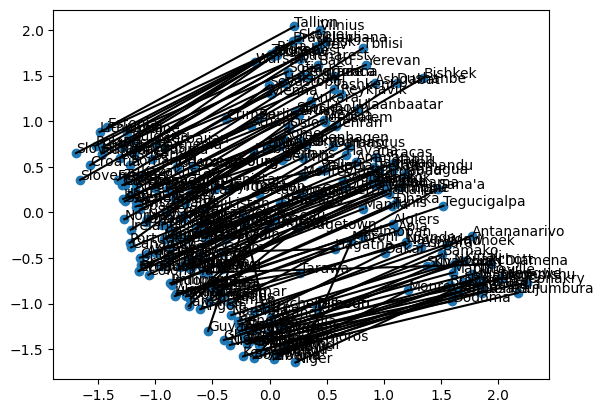

In [ ]:
#
# TODO
# use PCA from sklearn.decomposition to project the countries and capitals into 2D.
# draw lines connecting each country with its capital
#
# Hint:
# - the function "annotate" can be used to put text onto the plot
#

pca = PCA(n_components=2)  
geo_vecs_2d = pca.fit_transform(geo_vecs)

plt.figure(figsize=(30,40))

fig, ax = plt.subplots()
ax.scatter(geo_vecs_2d[:, 0], geo_vecs_2d[:, 1])  

for i in range(len(geo) // 2):
    country = geo[i * 2]
    capital = geo[i * 2 + 1]
    country_vec = geo_vecs_2d[i * 2]
    capital_vec = geo_vecs_2d[i * 2 + 1]
    
    ax.plot([country_vec[0], capital_vec[0]], [country_vec[1], capital_vec[1]], 'k-')
    
    ax.annotate(country, (country_vec[0], country_vec[1])) 
    ax.annotate(capital, (capital_vec[0], capital_vec[1]))

plt.show()

## 1.4: PCA vs t-SNE on frequent words

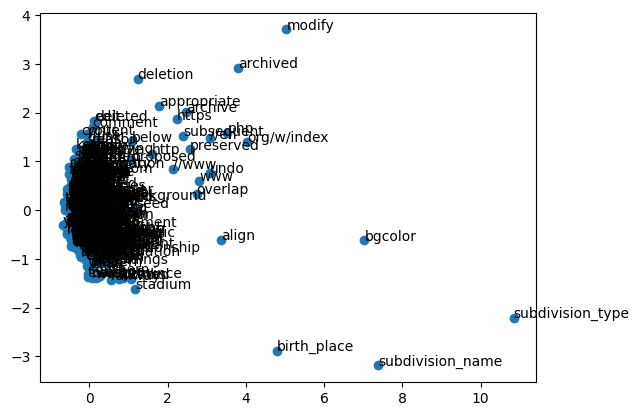

In [ ]:
# Select words starting from the 200th to ommit stop words,
# which have at least 3 chars
top_words = [w for (i,w) in enumerate(ftext.idx2word) \
             if i > 200 and len(w) >= 3][:400]
top_inds = [ftext.word2idx[w] for w in top_words]

word_vecs = ftext.vec[top_inds]

pca = PCA(n_components=2)
word_vecs_2d = pca.fit_transform(word_vecs)
#
# TODO: make a 2D PCA projection of the selected words.
#

fig, ax = plt.subplots()
ax.scatter(word_vecs_2d[:, 0], word_vecs_2d[:, 1])

for i, word in enumerate(top_words):
    ax.annotate(word, (word_vecs_2d[i, 0], word_vecs_2d[i, 1]))

plt.show()

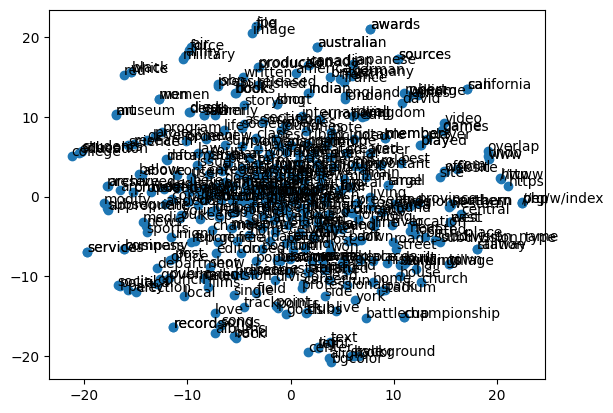

In [ ]:
from sklearn.manifold import TSNE

#
# TODO: make a 2D t-SNE projection of the selected words.
# Things will cluster much nicer
#
tsne = TSNE(n_components=2)
word_vecs_2d = tsne.fit_transform(word_vecs)

fig, ax = plt.subplots()
ax.scatter(word_vecs_2d[:, 0], word_vecs_2d[:, 1])

for i, word in enumerate(top_words):
    ax.annotate(word, (word_vecs_2d[i, 0], word_vecs_2d[i, 1]))

plt.show()